In [12]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from collections import Counter
import numpy as np
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy, Statevector, shannon_entropy
from qiskit_experiments.library import StateTomography
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator  # For simulation comparison




In [13]:
# Initialize your QiskitService
qiskit_service = QiskitService(str(Path.cwd() / ".env"))

# Select the backend
backend = qiskit_service.get_least_busy_backend()

Connected to IBM Quantum.


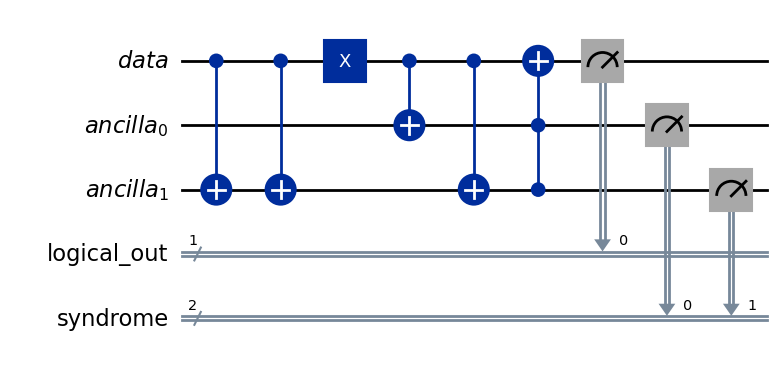

In [14]:

# Create a circuit with a register of three qubits
data = QuantumRegister(1,'data')
ancilla = QuantumRegister(2,'ancilla')
logical_out = ClassicalRegister(1,'logical_out')
syndrome = ClassicalRegister(2,'syndrome')
circuit = QuantumCircuit(data, ancilla, logical_out, syndrome)
circuit.cx(data[0], ancilla[1])
circuit.cx(data[0], ancilla[1])
circuit.x(data[0])
circuit.cx(data[0], ancilla[0])
circuit.cx(data[0], ancilla[1])
circuit.ccx(ancilla[1], ancilla[0], data[0])
circuit.measure(data[0], logical_out[0])
circuit.measure(ancilla[0], syndrome[0])
circuit.measure(ancilla[1], syndrome[1])
# Draw the circuit
circuit.draw('mpl') 

In [ ]:
preset_manager = generate_preset_pass_manager(backend=backend, 
                                  optimization_level=3)
preset_circuit = preset_manager.run(circuit)
job = Sampler(mode=backend).run([(preset_circuit)])
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: cztkmkanhqag008sze6g, 
 Job Status: QUEUED


In [ ]:
result = job.result()
pub_result = result[0]
print(f"Counts for the 'data' output register: {pub_result.data.logical_out.get_counts()}")
print(f"Counts for the 'syndrome' output register: {pub_result.data.syndrome.get_counts()}")

Counts for the 'data' output register: {'1': 513, '0': 3583}
Counts for the 'synrome' output register: {'00': 87, '11': 3371, '01': 331, '10': 307}


In [23]:
logical_out_counts = pub_result.data.logical_out.get_counts()

total_shots = sum(logical_out_counts.values())

probability_vector = [count / total_shots for count in logical_out_counts.values()]

entropy_value = shannon_entropy(probability_vector)
print(f"\nShannon Entropy (logical_out): {entropy_value:.6f}")

syndrome_counts = pub_result.data.syndrome.get_counts()
syndrome_probability_vector = [count / total_shots for count in syndrome_counts.values()]

syndrome_entropy_value = shannon_entropy(syndrome_probability_vector)
print(f"Shannon Entropy (syndrome): {syndrome_entropy_value:.6f}")


Shannon Entropy (logical_out): 0.544249
Shannon Entropy (syndrome): 0.922775
